# This notebook is concerned with handling Item Name
We'll be dealing with: 
- a mix of Arabic and English entries,
- item codes/numerical values,
- and lack of clear categorization.

Approach:
1. Basic normalization
    - normalize letters and words
    - remove incomplete words
    - remove fillers
    - remove unnecessary chars/symbols
2. Break corpus into string tokens
3. Generate Arabic lexicon from whole words
    - Calculate unigram probability + Laplace Smoothing 
4. Combine disjointed letters into full words based on the lexicon
    - Trie traverse + probabilities
5. Analyze tokens in the data
6. Devise normalization → reduced tokens
7. Tokenize to numerical features
8. Train a classifier (or classify manually) into interpretable categories
9. Spend analysis-ready

# Table of contents
- [Setup and load data](#setup-and-load-data)
- [Handling Item Names](#Handling-Item-Names)
    - [Basic normalization](#basic-normalization)
    - [Arabic lexicon](#string-tokens)
        - [Visualize lexicon frequency](#visualize-lexicon-frequency)
    - [Combine disjointed letters](#Combine-disjointed-letters)
    - [Analyze tokens](#Analyze-tokens)
    - [Reduced tokens](#reduced-tokens)
    - [Tokenize numerical](#Tokenize-numerical)
- [Train classifier](#Train-classifier)

- [Appendix](#Appendix)
    - [Tests](#tests)
        - [Trying out normalization techniques](#trying-out-normlization-techniques)
        - [Failed attempts by ChatGPT that took far too much time to test and had minimal improvements](#failed-attempts-by-chatgpt-that-took-far-too-much-time-to-test-and-had-minimal-improvements)

# Setup and load data

In [105]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log

from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants: أ إ آ -> ا
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar,    # ة -> ه or keep ة depending on needs
    normalize_unicode            # Normalize Unicode strings into their canonically composed form
)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize

import re
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
data_path = "../data/cleaned_num.xlsx"
df_original = pd.read_excel(data_path)
df = df_original.copy()

# For now we just care about Item Name
df = df[['Item Name']]

# Handling Item Names

## Basic normalization
Using CAMeL-Tools since it handles both Arabic and English texts

In [72]:
def normalize_text(text):
    text = normalize_unicode(text)
    text = dediac_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = text.strip()
    return text

df['Normalized'] = df['Item Name'].apply(normalize_text)

In [73]:
# Let's see the results - yes I noticed some entries are split (like 1563) which really gave me a headache trying to solve lol
df.iloc[[301, 901, 1563]]

,Item Name,Normalized
301,فرشة سرايا 6.5 مم PB7 برونزالفاء (PCS),فرشه سرايا 6.5 مم PB7 برونزالفاء (PCS)
901,GATE BARIAR PANEL2,GATE BARIAR PANEL2
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,ص ا ج ا س و د 10 م ل 8 * 4 م ت


In [97]:
# Now we'll normalize the text further to ensure we only have Arabic and English characters
def is_arabic_char(c: str) -> bool:
    return '\u0600' <= c <= '\u06FF'

def is_english_char(c: str) -> bool:
    return c.isascii() and c.isalpha()

def keep_arabic_english_only(c: str) -> str:
    if is_arabic_char(c) or is_english_char(c):
        return c
    return " "  # replace everything else with space

def basic_normalization(text, trim=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)

    # 3) Split on whitespace (since we've cleaned everything else to spaces)
    tokens = text.split()

    # 4) Drop single-letter tokens, repeated chars, and deduplicate within the row
    if trim:
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        counts = Counter(tokens)
        tokens = [t for t in tokens if counts[t] == 1]
        return ' '.join(tokens)
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)
    
df["Normalized"] = df["Item Name"].apply(basic_normalization, trim=True)
df["Disjointed"] = df["Item Name"].apply(basic_normalization, trim=False)
print("Before normalization:", "حديد تسليح مجدول سعودي سابك 12 مم * 12 م")
print("After normalization:", basic_normalization("حديد تسليح مجدول سعودي سابك 12 مم * 12 م"))
print("-----------------")
print("Disjoint - before:", "ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ")
print("Disjoint - after:", basic_normalization("ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ", trim=False))

Before normalization: حديد تسليح مجدول سعودي سابك 12 مم * 12 م
After normalization: حديد تسليح مجدول سعودي سابك
-----------------
Disjoint - before: ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ
Disjoint - after: حديدمجدولسابكملممترسعودي


In [99]:
df.iloc[[301, 901, 1563]]

,Item Name,Normalized,Disjointed
301,فرشة سرايا 6.5 مم PB7 برونزالفاء (PCS),فرشه سرايا PB برونزالفاء PCS,
901,GATE BARIAR PANEL2,GATE BARIAR PANEL,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت


Good, now we have normalized Arabic and English words, but also the disjointed chars are saved for later

## Arabic lexicon

In [77]:
corpus = df['Normalized']
tokens = [simple_word_tokenize(text) for text in corpus]

In [78]:
len(tokens)

3150

In [ ]:
# Lexicon is in Arabic, so we'll remove english for now
def is_arabic(token):
    return bool(re.search(r'[\u0600-\u06FF]', token))

arabic_tokens = [tok for row in tokens for tok in row if is_arabic(tok)]
lexicon = Counter(arabic_tokens)

In [111]:
# How many words did we get?
lexicon.__len__()

787

In [112]:
# Let's quickly check the most frequent words used
lexicon.most_common(10)

[('حديد', 516),
 ('تسليح', 308),
 ('سابك', 212),
 ('متر', 162),
 ('ملم', 145),
 ('اسود', 141),
 ('سماكه', 130),
 ('صاج', 126),
 ('اتفاق', 78),
 ('ماسوره', 73)]

### Visualize lexicon frequency

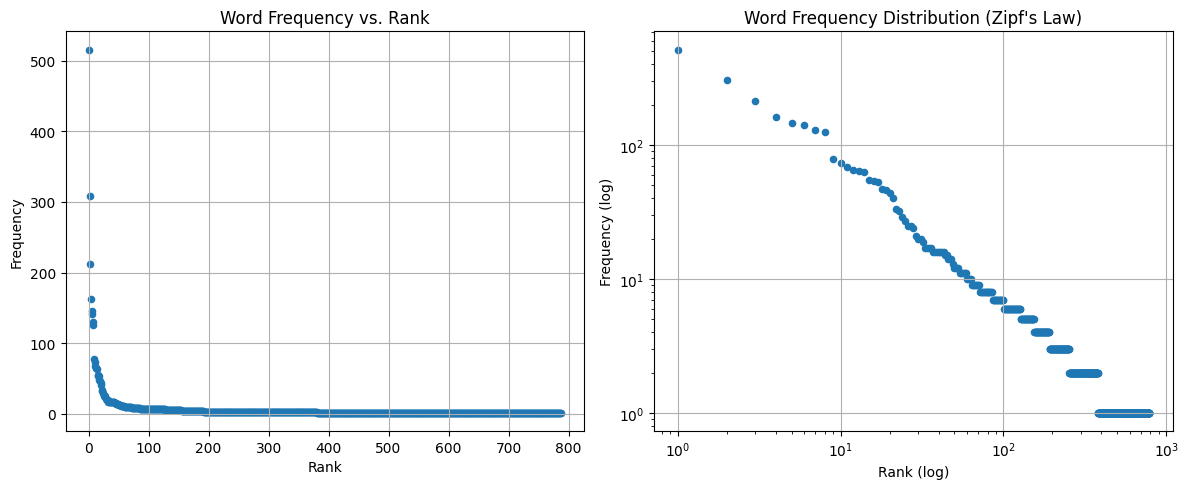

In [ ]:
# Sort frequencies descending
freqs_sorted = np.array(sorted(lexicon.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted)+1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- 1) Simple scatter plot ---
axes[0].scatter(ranks, freqs_sorted, s=20)
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Word Frequency vs. Rank")
axes[0].grid(True)

# --- 2) Zipf's Law (log-log) plot ---
axes[1].scatter(ranks, freqs_sorted, s=20)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("Rank (log)")
axes[1].set_ylabel("Frequency (log)")
axes[1].set_title("Word Frequency Distribution (Zipf's Law)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

This might be an extreme case of Zipf's law, but the frequency of the word is strongly inversely related to its rank

Nonetheless, when reconstructing the words from the disjoint words, we'll ensure that we give more frequent words more weight, sort of a probabilistic approach. The priors being the frequency of the term in the lexicon relative to the other terms.

## Combine disjointed letters
Combining the letters based on the lexicon is only one half of the solution, the other is to know what parts of the token we should look up in the lexicon and which parts should be omitted. 

### Research findings
This problem could be cut in three parts:
1. find unigram probability for each lexicon entry
2. create a Trie data structure from the lexicon
3. traverse the Trie and determine the word with most likelihood

In [128]:
class TrieNode: # Node definition for the Trie
    __slots__ = ("ch","end","logp")
    def __init__(self):
        self.ch = {}
        self.end = False
        self.logp = float("-inf")

class Trie:
    def __init__(self):
        self.root = TrieNode()
    def insert(self, word, logp): # Insert a node in the Trie
        node = self.root
        for c in word:
            node = node.ch.setdefault(c, TrieNode())
        node.end = True
        node.logp = logp
    def in_trie_prefix(self, s): # Checks if the string/word is in our Trie
        node = self.root
        for ch in s:
            if ch not in node.ch:
                return False
            node = node.ch[ch]
        return node.end

def build_trie_from_counts(counts, alpha=0.0):
    # counts: dict[word] -> int
    V = len(counts) # Vocabulary size
    Z = sum(counts.values()) + alpha * V # Denominator = N_train (total no. of words) + weighted V
    T = Trie()
    for w, c in counts.items():
        p = (c + alpha) / Z
        T.insert(w, log(p))
    return T

def viterbi_segment(chars, trie):
    """chars: e.g. 'catsanddog' (spaces removed). Returns words and score."""
    n = len(chars)
    best = [float("-inf")] * (n + 1)
    back = [None] * (n + 1)
    best[n] = 0.0  # empty suffix has score 0

    for i in range(n - 1, -1, -1):
        node = trie.root
        j = i
        while j < n and chars[j] in node.ch:
            node = node.ch[chars[j]]
            j += 1
            if node.end:
                cand = node.logp + best[j]
                if cand > best[i]:
                    best[i] = cand
                    back[i] = (j, j - i)  # next index and word length
        # Allow an UNK token by charging a penalty:
        # if best[i] == -inf:
        #     best[i] = unk_logp + best[i+1]; back[i]=(i+1,1)

    if best[0] == float("-inf"):
        return None, float("-inf")

    # reconstruct
    words = []
    i = 0
    while i < n:
        j, L = back[i]
        words.append(chars[i:j])
        i = j
    return words, best[0]


In [129]:
# Toy example
counts = {
    "cat": 50, "cats": 30, "sand": 25, "and": 100, "dog": 70, "an": 150
}
trie = build_trie_from_counts(counts, alpha=1.0)
words, score = viterbi_segment("catsanddog", trie)
print(words)  # e.g., ['cats', 'and', 'dog'] because logP(cats)+logP(and)+logP(dog) is maximal


['cats', 'and', 'dog']


In [132]:
# Example from our data

trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود', 'مل', 'مت'] -20.187830194356444


In [134]:
words, score = viterbi_segment("صاج", trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج'] -3.7777264157280492


In [135]:
chars = "صاجاسودملمت"
counts = {"صاج" : 1, "اسود" :1, "ملمت" : 1}

trie = build_trie_from_counts(lexicon)
seg, score = viterbi_segment(chars, trie_ar)

print(seg, score)

['صاج', 'اسود', 'مل', 'مت'] -20.187830194356444


In [ ]:
print("صاج in trie?", trie_ar.in_trie_prefix("صاج"))

صاج in trie? True


## Analyze tokens

## Reduced tokens

## Numerical tokens

# Train classifier

# Appendix

## Tests

### Trying out normlization techniques

In [34]:
text = "ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ"
text

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [ ]:
# This does a good job in standardizing the characters
import unicodedata
result = unicodedata.normalize("NFKC", text)
result

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [36]:
import re
result = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', text)
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [38]:
result = re.sub(r'\s+', ' ', text).strip()
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

None of the techniques above effictively resolves the issue of spaces and word recognition in text...

We'll try out Camel-tools, I've had a little experience with it before, but never worked with data this messy

In [39]:
import camel_tools.utils.normalize as norm

In [ ]:
norm.normalize_unicode(text)

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [66]:
from camel_tools.utils.dediac import dediac_ar
dediac_ar(norm.normalize_unicode(text))

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

### Failed attempts by ChatGPT that took far too much time to test and had minimal improvements

In [ ]:
import re
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar

# Unicode ranges that cover Arabic letters (not presentation forms)
_AR = r'\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'

def normalize_mixed_arabic(s: str) -> str:
    # 1) Canonical/compatibility normalization
    s = normalize_unicode(s, compatibility=True)
    # 2) Normalize alef maqsura, optional but useful
    s = normalize_alef_maksura_ar(s)

    # 3) Strip zero-width/bidi formatting chars
    s = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', s)

    # 4) Normalize common operators and pad them
    #    Treat *, ×, x as multiplication; surround with single spaces
    s = re.sub(r'\s*([*xX×])\s*', r' × ', s)

    # 5) **Key step**: remove spaces *only* between Arabic letters
    #    This stitches scattered letters back into words
    s = re.sub(fr'(?<=[{_AR}])\s+(?=[{_AR}])', '', s)

    # 6) Collapse remaining excessive whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# Demo on your string
sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(normalize_mixed_arabic(sample))


تیوبفارغمربع 80 × 80 × 5 مل 6 متر


In [60]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# 1) choose a pretrained analyzer/disambiguator (MSA shown)
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# 2) after your intra-letter stitching + spacing heuristics:
clean = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"#"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

['تیوبفارغمربع', '80', '×', '80', '×', '5', 'مل', '6', 'متر']

In [ ]:
import re
import unicodedata
from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar     # ة -> ه or keep ة depending on needs
)
from camel_tools.utils.dediac import dediac_ar

# Arabic block after NFKC
ARABIC_RANGE = r"\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF"
AR_LETTER = f"[{ARABIC_RANGE}]"
DIGIT = r"[0-9\u0660-\u0669]"  # Western + Arabic-Indic

def to_ascii_digits(s: str) -> str:
    # map Arabic-Indic digits to ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")
    return s.translate(trans)

def normalize_ar_text(s: str, keep_diacritics=False):
    # 1) collapse presentation forms, compatibility, widths, etc.
    s = unicodedata.normalize("NFKC", s)

    # 2) remove tatweel and bidi/formatting chars
    s = s.replace("\u0640", "")  # tatweel
    s = re.sub(r"[\u200c\u200d\u200e\u200f\u061c]", "", s)  # ZWNJ/ZWJ/LRM/RLM/ALM

    # 3) unify common Arabic variants
    s = normalize_alef_ar(s)
    s = normalize_alef_maksura_ar(s)
    s = normalize_teh_marbuta_ar(s)

    # 4) optional: strip diacritics (recommended for noisy sources)
    if not keep_diacritics:
        s = dediac_ar(s)

    # 5) digits to ASCII for easier heuristics
    s = to_ascii_digits(s)

    return s

def fix_spaced_glyphs(s: str):
    s = normalize_ar_text(s)

    # --- spacing repair heuristics ---

    # A) collapse spaces inserted between Arabic letters (re-form words)
    # remove spaces when both sides are Arabic letters
    s = re.sub(fr"(?<={AR_LETTER})\s+(?={AR_LETTER})", "", s)

    # B) ensure spaces around math operators and 'x'
    s = re.sub(r"\s*([*+\-/x×])\s*", r" \1 ", s)

    # C) split between letters and digits (both directions)
    s = re.sub(fr"(?<={AR_LETTER})(?={DIGIT})", " ", s)
    s = re.sub(fr"(?<={DIGIT})(?={AR_LETTER})", " ", s)

    # D) heuristic: insert a space when a right-joining (non-connecting-left) letter
    # is followed by another letter (helps recover word boundaries)
    non_joiners = "ادذرزوةى"  # letters that do not connect to the following letter
    s = re.sub(fr"(?<=[{non_joiners}])(?={AR_LETTER})", " ", s)

    # E) normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(fix_spaced_glyphs(sample))


تیو بفا ر غمر بع 80 * 80 * 5 مل 6 متر
